<a href="https://colab.research.google.com/github/SamuelSS09/face-mask-detection-projet-s9/blob/main/Test_MobilNetV2_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source 1 : https://github.com/HOD101s/Face-Mask-Detection

Source 2 : https://github.com/mk-gurucharan/Face-Mask-Detection

In [390]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil

from shutil import copyfile

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


Fetching Our Data


In [391]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [392]:
!unzip -q "/content/drive/MyDrive/S9/PROJET S9/Classification/Codes/Datasets/3classes_real_reduced_dataset.zip" -d "/content/datasets/"
# !unzip -q "/content/drive/MyDrive/S9/PROJET S9/Classification/Codes/Datasets/3classes_simulated_dataset.zip" -d "/content/datasets/"

replace /content/datasets/__MACOSX/._3classes_real_reduced_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [393]:
base = '/content/drive/MyDrive/S9/PROJET S9/Classification/Codes/'
# MODEL_DESCRIPTION = '3classes_simulated_MobNotTrainable' 
MODEL_DESCRIPTION = '3classes_FineTunning_MobNotTrainable' 

DATAPATH = os.path.join('datasets/3classes_real_reduced_dataset/')
MASK_PATH = os.path.join(DATAPATH,'well_ported_mask/')
NO_MASK_PATH = os.path.join(DATAPATH,'no_mask/')
WRONG_MASK_PATH = os.path.join(DATAPATH,'wrong_ported_mask/')

TRAIN_PATH = os.path.join(DATAPATH,'traindata/')
TRAIN_MASK_PATH = os.path.join(DATAPATH,'traindata/well_ported_mask/')
TRAIN_NO_MASK_PATH = os.path.join(DATAPATH,'traindata/no_mask/')
TRAIN_WRONG_MASK_PATH = os.path.join(DATAPATH,'traindata/wrong_ported_mask/')

VAL_PATH = os.path.join(DATAPATH,'valdata/')
VAL_MASK_PATH = os.path.join(DATAPATH,'valdata/well_ported_mask/')
VAL_NO_MASK_PATH = os.path.join(DATAPATH,'valdata/no_mask/')
VAL_WRONG_MASK_PATH = os.path.join(DATAPATH,'valdata/wrong_ported_mask/')

FIG_PATH = os.path.join(base,'fig/')
os.makedirs(FIG_PATH,exist_ok= True)
ACCUR_FIG_PATH = os.path.join(FIG_PATH,f'Accuracy_{MODEL_DESCRIPTION}.png')
LOSS_FIG_PATH = os.path.join(FIG_PATH,f'Loss_{MODEL_DESCRIPTION}.png')


# TESTPATH = os.path.join(base,'our_dataset/testdata/')
# TEST_MASK_PATH = os.path.join(base,'our_dataset/testdata/mask/')
# TEST_NOMASK_PATH = os.path.join(base,'our_dataset/testdata/no_mask/')

WEIGHTS_PATH = os.path.join(base,'weights/')
os.makedirs(WEIGHTS_PATH,exist_ok = True)
WEIGHTS_FILE = os.path.join(WEIGHTS_PATH,f'{MODEL_DESCRIPTION}.h5')
CHECKPOINTS_PATH = os.path.join(base, 'checkpoints/')
HIST_PATH = os.path.join(base,'history/')
HIST_FILE = os.path.join(HIST_PATH,f'{MODEL_DESCRIPTION}.csv')
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TRAIN_MASK_PATH, exist_ok=True)
os.makedirs(TRAIN_NO_MASK_PATH, exist_ok=True)
os.makedirs(TRAIN_WRONG_MASK_PATH, exist_ok=True)

os.makedirs(VAL_PATH, exist_ok=True)
os.makedirs(VAL_MASK_PATH, exist_ok=True)
os.makedirs(VAL_NO_MASK_PATH, exist_ok=True)
os.makedirs(VAL_WRONG_MASK_PATH, exist_ok=True)
os.makedirs(HIST_PATH, exist_ok=True)

trainable = False
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 5e-5
fine_tunning = True
initial_weights = os.path.join(WEIGHTS_PATH,'3classes_simulated_MobNotTrainable.h5')

Visualizing our data

In [394]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

In [395]:
NumberMaskData = os.listdir(MASK_PATH)
print(len(NumberMaskData))

298


In [396]:
NumberNOMaskData = os.listdir(NO_MASK_PATH)
print(len(NumberNOMaskData))

375


In [397]:
NumberWrongMaskData = os.listdir(WRONG_MASK_PATH)
print(len(NumberWrongMaskData))

202


In [398]:
# view(MASKPATH)

In [399]:
# view(NOMASKPATH)

Analysing our Data

In [400]:
fig = go.Figure(
    data=[go.Pie(labels=['WITHMASK','WITHOUTMASK','WRONGMASK'], 
        values=[NumberMaskData , NumberNOMaskData , NumberWrongMaskData ])
    ])
fig.show()

In [401]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)


To clean the NO_MASK and MASK folders

In [402]:

from pathlib import Path


[f.unlink() for f in Path(TRAIN_MASK_PATH).glob("*") if f.is_file()] 
[f.unlink() for f in Path(TRAIN_NO_MASK_PATH).glob("*") if f.is_file()] 

# [f.unlink() for f in Path(TEST_MASK_PATH).glob("*") if f.is_file()] 
# [f.unlink() for f in Path(TEST_NOMASK_PATH).glob("*") if f.is_file()] 

[f.unlink() for f in Path(VAL_MASK_PATH).glob("*") if f.is_file()] 
[f.unlink() for f in Path(VAL_NO_MASK_PATH).glob("*") if f.is_file()] 

print("The training set mask/no_mask/wrong_mask sizes: (",len(os.listdir(TRAIN_MASK_PATH)),",",len(os.listdir(TRAIN_NO_MASK_PATH)),",",len(os.listdir(TRAIN_WRONG_MASK_PATH)),")")
print("The test set mask/no_mask/wrong_mask sizes: (",len(os.listdir(VAL_MASK_PATH)),",",len(os.listdir(VAL_NO_MASK_PATH)),",",len(os.listdir(VAL_WRONG_MASK_PATH)),")")
# print("The test set mask/no_mask sizes: (",len(os.listdir(TEST_MASK_PATH)),",",len(os.listdir(TEST_NOMASK_PATH)),")")

The training set mask/no_mask/wrong_mask sizes: ( 0 , 0 , 195 )
The test set mask/no_mask/wrong_mask sizes: ( 0 , 0 , 75 )


In [403]:
split_size = .80
split_data(MASK_PATH, TRAIN_MASK_PATH, VAL_MASK_PATH, split_size)
split_data(NO_MASK_PATH, TRAIN_NO_MASK_PATH, VAL_NO_MASK_PATH, split_size)
split_data(WRONG_MASK_PATH, TRAIN_WRONG_MASK_PATH, VAL_WRONG_MASK_PATH, split_size)

In [404]:
print("The number of images with facemask in the training set:", len(os.listdir(TRAIN_MASK_PATH)))
print("The number of images without facemask in the training set:", len(os.listdir(TRAIN_NO_MASK_PATH)))
print("The number of images with improperly worn mask in the validation set:", len(os.listdir(TRAIN_WRONG_MASK_PATH)))
print("The number of images with facemask in the test set:", len(os.listdir(VAL_MASK_PATH)))
print("The number of images without facemask in the validation set:", len(os.listdir(VAL_NO_MASK_PATH)))
print("The number of images with improperly worn mask in the validation set:", len(os.listdir(VAL_WRONG_MASK_PATH)))

The number of images with facemask in the training set: 238
The number of images without facemask in the training set: 300
The number of images with improperly worn mask in the validation set: 195
The number of images with facemask in the test set: 60
The number of images without facemask in the validation set: 75
The number of images with improperly worn mask in the validation set: 75


Preparing Data Input Pipelines

In [405]:
trainGen = ImageDataGenerator(rescale=1.0/255.0,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

testGen = ImageDataGenerator(
    rescale= 1.0/255.0,
)

Ref : https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [406]:
train = trainGen.flow_from_directory(
    TRAIN_PATH, 
    target_size=(128, 128),
    classes=['no_mask','well_ported_mask', 'wrong_ported_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

validation = testGen.flow_from_directory(
    VAL_PATH, 
    target_size=(128, 128),
    classes=['no_mask','well_ported_mask', 'wrong_ported_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False,
)


Found 731 images belonging to 3 classes.
Found 210 images belonging to 3 classes.


Model Building

In [407]:
mob = MobileNetV2(
    input_shape = (128,128,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = trainable


TRANSFER TRAINING

In [408]:
model = Sequential()
model.add(mob)
model.add(GlobalMaxPool2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_14 (Glo (None, 1280)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                81984     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 195       
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_________________________________________________________________


In [409]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),loss='categorical_crossentropy',metrics=['accuracy'])

if fine_tunning:
  model.load_weights( initial_weights )

In [410]:
# checkpoint_filepath3 = "/content/drive/My Drive/PROJET S9/Classification/Codes/check_points3"

checkpoint = ModelCheckpoint(
    CHECKPOINTS_PATH,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)


Ref : https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd

In [411]:
early_stopping = EarlyStopping(monitor='val_loss', 
                                patience=5, 
                                min_delta=0.001, 
                                mode='max')
# while monitoring val_accuraccy model achieve 1.00 result at 17 epochs

Ref : https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

In [412]:
STEP_SIZE_TRAIN=train.n//train.batch_size
STEP_SIZE_VALID=validation.n//validation.batch_size

print("Steps in training set:", STEP_SIZE_TRAIN)
print("Steps in validation set:", STEP_SIZE_VALID)

Steps in training set: 11
Steps in validation set: 3


In [413]:
history = model.fit(train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS 
)



Epoch 1/30
11/11 [==============================] - 6s 389ms/step - loss: 2.8275 - accuracy: 0.5109 - val_loss: 1.9711 - val_accuracy: 0.4792
Epoch 2/30
11/11 [==============================] - 3s 272ms/step - loss: 2.0816 - accuracy: 0.5061 - val_loss: 1.6791 - val_accuracy: 0.5052
Epoch 3/30
11/11 [==============================] - 3s 272ms/step - loss: 1.5744 - accuracy: 0.5310 - val_loss: 1.5150 - val_accuracy: 0.5104
Epoch 4/30
11/11 [==============================] - 3s 257ms/step - loss: 1.4020 - accuracy: 0.5254 - val_loss: 1.3836 - val_accuracy: 0.5156
Epoch 5/30
11/11 [==============================] - 3s 262ms/step - loss: 1.1462 - accuracy: 0.5607 - val_loss: 1.2641 - val_accuracy: 0.5104
Epoch 6/30
11/11 [==============================] - 3s 262ms/step - loss: 1.1245 - accuracy: 0.5490 - val_loss: 1.1658 - val_accuracy: 0.5156
Epoch 7/30
11/11 [==============================] - 3s 259ms/step - loss: 0.9141 - accuracy: 0.6284 - val_loss: 1.0938 - val_accuracy: 0.5208
Epoch 

In [414]:
import pandas as pd

hist_df = pd.DataFrame(history.history) 

with open(HIST_FILE, mode='w') as f:
    hist_df.to_csv(f)


In [415]:
# The model weights (that are considered the best) are loaded into the model.
model.save_weights(WEIGHTS_FILE)
#model.load_weights(checkpoint_filepath2)

In [416]:
model.evaluate(validation, steps=STEP_SIZE_VALID)

3/3 [==============================] - 0s 60ms/step - loss: 0.7016 - accuracy: 0.6406


[0.701612651348114, 0.640625]

In [417]:
# summarize history for accuracy

# to write in a good resolution - accuracy
plt.figure(num=None, figsize=(8, 6), dpi=320)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.savefig(ACCUR_FIG_PATH)
plt.close()

# to write in a good resolution - loss
plt.figure(num=None, figsize=(8, 6), dpi=320)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.savefig(LOSS_FIG_PATH)
plt.close()

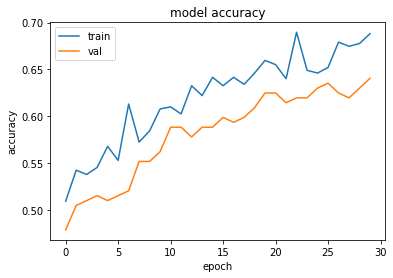

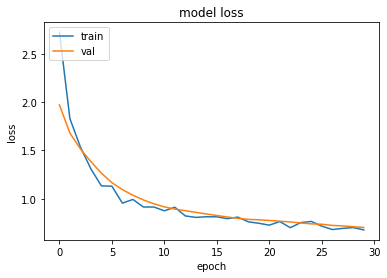

In [418]:
#for quick visualization - accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Points to check : https://cs231n.github.io/neural-networks-3/#sanitycheck

NOTES:

- Tester les codes sur 10 images (e.g) pour voir si le code marche bien
- Voir la sortie de MobileNetV2
- Le CNN doit voir si la partie basse de l'image est dense
- Peut etre ajouter un 3eme set de validation (pour le moment on a train et test)
- Entrainer sur moins d'images au depart
- Comment mesurer la vitesse d'execution du code??
